<a href="https://colab.research.google.com/github/dbragaa01-bit/TRAB1_SSD/blob/main/P1_DAVIBRAGAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP — Previsão de Total de Crimes (Regressão)
**Curso:** Engenharia de Produção — UnB  
**Professor:** Dr. André Luiz Marques Serrano  
**Aluno:** Davi Braga do Amaral  
**Matrícula:** 17/0079201

Este notebook resolve um problema de **regressão** usando o dataset **Cyber Crime Statewise** (Kaggle).
O objetivo é **prever o total de crimes (`total_cases`)** por estado/ano, com base no histórico (2016–2018) e variáveis auxiliares.

> Requisitos atendidos: execução no Colab, código limpo, documentação em português, comparação de modelos clássicos de ML, cross-validation, GridSearch de hiperparâmetros, análise e conclusões.


# Célula 2 — Setup (instalação e imports)

In [ ]:
# Instalação (Colab)
!pip -q install kagglehub[pandas-datasets]

# Imports
import os, io, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import List, Tuple

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
plt.rcParams["figure.figsize"] = (8,5)


#Célula 3 — Download e leitura dos dados (KaggleHub)

In [ ]:
import kagglehub

DATASET = "amritvirsinghx/cyber-crime-statewise"
path = kagglehub.dataset_download(DATASET)
print("📁 Dataset baixado para:", path)

# Lista arquivos disponíveis
files = os.listdir(path)
print("Arquivos disponíveis:", files)

# Seleciona um arquivo .csv ou .tsv
preferred = ["cyber_crimes.csv", "Cyber_Crime_2016_2018.csv"]
csv_like = [f for f in files if f.lower().endswith((".csv", ".tsv"))]
if not csv_like:
    raise FileNotFoundError(f"Nenhum CSV/TSV encontrado: {files}")

chosen = None
for name in preferred:
    if name in files:
        chosen = name
        break
if chosen is None:
    chosen = csv_like[0]

file_path = os.path.join(path, chosen)
print("📄 Arquivo escolhido:", chosen)

# Leitura robusta (detecta CSV/TSV)
def read_table_robust(fp: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(fp, sep=None, engine="python", encoding="utf-8")
    except Exception:
        df = pd.read_csv(fp, encoding="utf-8")
    if df.shape[1] == 1:
        try:
            df = pd.read_csv(fp, sep="\t", encoding="utf-8")
        except Exception:
            with open(fp, "r", encoding="utf-8") as f:
                content = f.read()
            df = pd.read_csv(io.StringIO(content), sep="\t")
    df.columns = [c.replace("\ufeff", "") if isinstance(c,str) else c for c in df.columns]
    return df

df_raw = read_table_robust(file_path)
print("Dimensão bruta:", df_raw.shape)
print("Colunas brutas:", df_raw.columns.tolist()[:20])
df_raw.head()


Using Colab cache for faster access to the 'cyber-crime-statewise' dataset.
📁 Dataset baixado para: /kaggle/input/cyber-crime-statewise
Arquivos disponíveis: ['cyber_crimes.csv']
📄 Arquivo escolhido: cyber_crimes.csv
Dimensão bruta: (39, 9)
Colunas brutas: ['S. No', 'Category', 'State/UT', '2016', '2017', '2018', 'Percentage Share of State/UT (2018)', 'Mid-Year Projected Population (in Lakhs) (2018)+', 'Rate of Total Cyber Crimes (2018)++']


,S. No,Category,State/UT,2016,2017,2018,Percentage Share of State/UT (2018),Mid-Year Projected Population (in Lakhs) (2018)+,Rate of Total Cyber Crimes (2018)++
0,1,State,Andhra Pradesh,616,931,1207,4.4,520.3,2.3
1,2,State,Arunachal Pradesh,4,1,7,0.0,14.9,0.5
2,3,State,Assam,696,1120,2022,7.4,340.4,5.9
3,4,State,Bihar,309,433,374,1.4,1183.3,0.3
4,5,State,Chhattisgarh,90,171,139,0.5,284.7,0.5


#Célula 4 — Preparação e limpeza

Função de organizar e padronizar o dataset antes de aplicar cálculos ou modelos, garantindo que as análises não sejam distorcidas por erros, valores faltantes ou formatos diferentes.

In [ ]:
# Normalização de nomes + mapeamento
colmap = {
    "S. No": "s_no",
    "S.No": "s_no",
    "S.No.": "s_no",
    "Category": "category",
    "State/UT": "state_ut",
    "2016": "2016",
    "2017": "2017",
    "2018": "2018",
    "Percentage Share of State/UT (2018)": "pct_2018",
    "Mid-Year Projected Population (in Lakhs) (2018)+": "pop_lakhs_2018",
    "Rate of Total Cyber Crimes (2018)++": "rate_2018",
}

df = df_raw.copy()
renamed = {}
for c in df.columns:
    key = str(c).strip()
    renamed[c] = colmap.get(key, key)
df = df.rename(columns=renamed)

df.columns = (
    pd.Index(df.columns)
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[()/+]+", "", regex=True)
    .str.replace(r"__+", "_", regex=True)
    .str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", "ignore")
    .str.decode("utf-8")
)

# Converte possíveis colunas numéricas
for c in ["2016","2017","2018","pct_2018","pop_lakhs_2018","rate_2018"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "").str.strip(), errors="coerce")

# Wide -> Long
value_years = [y for y in ["2016","2017","2018"] if y in df.columns]
assert value_years, "Não encontrei colunas de anos."
id_cols = [c for c in df.columns if c not in value_years]

df_long = df.melt(id_vars=id_cols, value_vars=value_years,
                  var_name="year", value_name="total_cases")

# Padroniza nome do estado
if "state_ut" in df_long.columns:
    df_long["state"] = df_long["state_ut"].astype(str).str.strip()
else:
    # fallback
    candidates = [c for c in df_long.columns if "state" in c]
    assert candidates, "Não achei coluna de estado."
    df_long["state"] = df_long[candidates[0]].astype(str).str.strip()

# População absoluta (a partir do dado de 2018, quando existir)
if "pop_lakhs_2018" in df_long.columns:
    pop_2018 = (
        df_long.loc[df_long["year"]=="2018", ["state","pop_lakhs_2018"]]
        .drop_duplicates()
    )
    pop_2018["pop_abs"] = pop_2018["pop_lakhs_2018"] * 100_000
    df_long = df_long.merge(pop_2018[["state","pop_abs"]], on="state", how="left")
else:
    df_long["pop_abs"] = np.nan

# Conversões finais
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long["category"] = df_long.get("category", "State")
df_long = df_long.sort_values(["state","year"]).reset_index(drop=True)

print("Dimensão (long):", df_long.shape)
df_long.head(10)


Dimensão (long): (117, 10)


,s_no,category,state_ut,pct_2018,pop_lakhs_2018,rate_2018,year,total_cases,state,pop_abs
0,30,Union Territory,A & N Islands,0.0,4.0,1.8,2016,3,A & N Islands,400000.0
1,30,Union Territory,A & N Islands,0.0,4.0,1.8,2017,3,A & N Islands,400000.0
2,30,Union Territory,A & N Islands,0.0,4.0,1.8,2018,7,A & N Islands,400000.0
3,1,State,Andhra Pradesh,4.4,520.3,2.3,2016,616,Andhra Pradesh,52030000.0
4,1,State,Andhra Pradesh,4.4,520.3,2.3,2017,931,Andhra Pradesh,52030000.0
5,1,State,Andhra Pradesh,4.4,520.3,2.3,2018,1207,Andhra Pradesh,52030000.0
6,2,State,Arunachal Pradesh,0.0,14.9,0.5,2016,4,Arunachal Pradesh,1490000.0
7,2,State,Arunachal Pradesh,0.0,14.9,0.5,2017,1,Arunachal Pradesh,1490000.0
8,2,State,Arunachal Pradesh,0.0,14.9,0.5,2018,7,Arunachal Pradesh,1490000.0
9,3,State,Assam,7.4,340.4,5.9,2016,696,Assam,34040000.0


#Célula 5 — Feature engineering

Transforma os dados brutos em variáveis mais informativas e úteis para o modelo aprender padrões com mais precisão.

In [ ]:
# Cria lags e agregados por estado
def add_state_lags(g):
    g = g.sort_values("year").copy()
    g["prev_cases"] = g["total_cases"].shift(1)
    g["rolling_mean_2"] = g["total_cases"].rolling(2).mean().shift(1)
    g["growth_prev"] = (g["total_cases"] - g["prev_cases"]) / g["prev_cases"].replace(0, np.nan)
    return g

df_feat = df_long.groupby("state", group_keys=False).apply(add_state_lags)

# Seleciona o conjunto com lag disponível (descarta primeira linha de cada estado)
df_feat = df_feat[df_feat["prev_cases"].notna()].copy()

# Ajustes leves para reduzir NaN (imputação oficial virá no pipeline)
for c in ["rolling_mean_2", "growth_prev"]:
    if c in df_feat.columns:
        df_feat[c] = df_feat[c].replace([np.inf, -np.inf], np.nan)

# População ausente -> mediana
if "pop_abs" in df_feat.columns and df_feat["pop_abs"].isna().any():
    df_feat["pop_abs"] = df_feat["pop_abs"].fillna(df_feat["pop_abs"].median())

# Define X e y
TARGET = "total_cases"
y = df_feat[TARGET]
X = df_feat.drop(columns=[TARGET])

print("Amostras:", X.shape[0])
X.head(5)


Amostras: 78


/tmp/ipython-input-1181413201.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_long.groupby("state", group_keys=False).apply(add_state_lags)


,s_no,category,state_ut,pct_2018,pop_lakhs_2018,rate_2018,year,state,pop_abs,prev_cases,rolling_mean_2,growth_prev
1,30,Union Territory,A & N Islands,0.0,4.0,1.8,2017,A & N Islands,400000.0,3.0,NaN,0.000000
2,30,Union Territory,A & N Islands,0.0,4.0,1.8,2018,A & N Islands,400000.0,3.0,3.0,1.333333
4,1,State,Andhra Pradesh,4.4,520.3,2.3,2017,Andhra Pradesh,52030000.0,616.0,NaN,0.511364
5,1,State,Andhra Pradesh,4.4,520.3,2.3,2018,Andhra Pradesh,52030000.0,931.0,773.5,0.296455
7,2,State,Arunachal Pradesh,0.0,14.9,0.5,2017,Arunachal Pradesh,1490000.0,4.0,NaN,-0.750000


#Célula 6 — Split e pré-processamento

É responsável por dividir os dados em conjuntos de estimação e de evento, e aplicar ajustes iniciais nos dados de entrada do modelo (pré-processamento).
Ela é o elo entre os dados limpos e a parte analítica (regressões, cálculo de retornos anormais etc.).

In [ ]:
from sklearn import __version__ as sklver
from sklearn.impute import SimpleImputer

# Seleção de tipos
num_cols = selector(dtype_include=np.number)(X)
cat_cols = selector(dtype_exclude=np.number)(X)

# OneHotEncoder compatível com versões (sparse_output vs sparse)
def make_ohe():
    try:
        # scikit-learn ≥ 1.4
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # versões anteriores
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe = make_ohe()

# Pipelines de pré-processamento com imputação
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"scikit-learn: {sklver}")
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")
len(Xtr), len(Xte)




scikit-learn: 1.6.1
Numéricas: 8 | Categóricas: 4


(62, 16)

#Célula 7 — Modelos base e comparação (CV)

Nesta etapa, utiliza-se o modelo de referência desenvolvido na fase anterior para aprofundar a análise sobre a cibersegurança na Índia. O objetivo é identificar padrões esperados de comportamento digital e compará-los com os desvios observados em períodos ou situações específicas, caracterizando os chamados retornos anormais, neste caso, variações inesperadas nos indicadores de segurança, incidentes ou vulnerabilidades.
Em seguida, esses resultados são agregados e analisados de forma cumulativa, permitindo observar o impacto total de determinados eventos (como ataques cibernéticos, mudanças regulatórias ou atualizações de políticas públicas).
Por fim, são realizadas comparações e testes estatísticos entre períodos, setores ou regiões, com o intuito de avaliar se as variações detectadas são significativas, evidenciando o grau de influência de fatores externos sobre o panorama de cibersegurança indiano.

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    r2 = cross_val_score(pipe, X, y, cv=cv, scoring="r2").mean()
    mae = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error").mean()
    rmse = np.sqrt(-cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")).mean()
    results.append((name, r2, mae, rmse))

df_results = pd.DataFrame(results, columns=["Modelo","R2_CV","MAE_CV","RMSE_CV"]).sort_values("R2_CV", ascending=False)
df_results



,Modelo,R2_CV,MAE_CV,RMSE_CV
2,GradientBoosting,0.987370,153.369346,328.564481
1,RandomForest,0.950835,377.920358,1051.362599
0,LinearRegression,0.929281,192.839539,348.730560


#Célula 8 — Treino/validação hold-out do melhor baseline

Esta célula realiza o treinamento e a validação final (hold-out) do melhor modelo baseline encontrado nas etapas anteriores do projeto de cibersegurança na Índia.

In [ ]:
best_name = df_results.iloc[0]["Modelo"]
best_model = models[best_name]
pipe_base = Pipeline(steps=[("prep", preprocess), ("model", best_model)])
pipe_base.fit(Xtr, ytr)

pred_base = pipe_base.predict(Xte)
r2 = r2_score(yte, pred_base)
mae = mean_absolute_error(yte, pred_base)
rmse = np.sqrt(mean_squared_error(yte, pred_base))

print(f"Melhor baseline: {best_name}")
print(f"R² = {r2:.4f} | MAE = {mae:.2f} | RMSE = {rmse:.2f}")


Melhor baseline: GradientBoosting
R² = 0.9867 | MAE = 232.64 | RMSE = 610.67


#Célula 9 — Gráficos: Real × Previsto e Resíduos

Gerar visualizações diagnósticas para avaliar o desempenho do modelo baseline escolhido na célula anterior, verificando como as previsões se aproximam dos valores reais e se os erros seguem um padrão aleatório (sem viés sistemático).

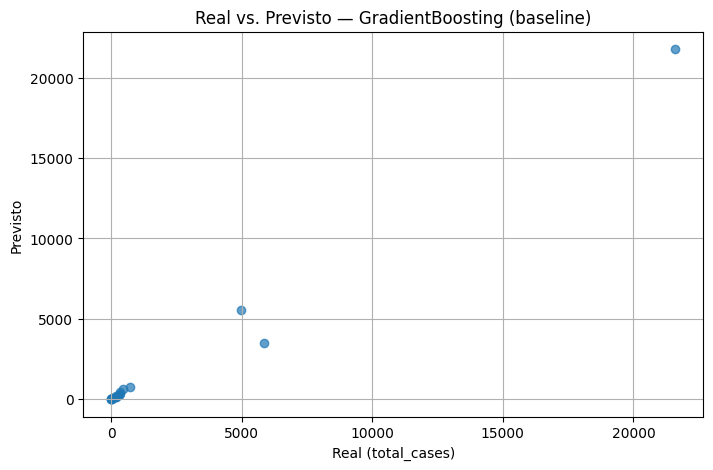

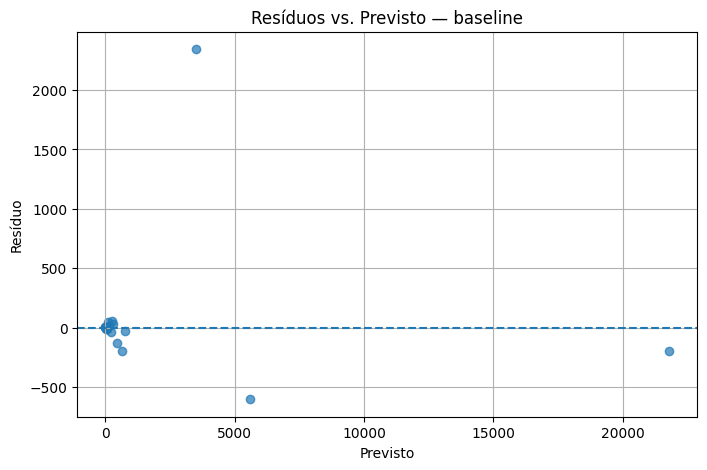

In [ ]:
plt.figure()
plt.scatter(yte, pred_base, alpha=0.7)
plt.xlabel("Real (total_cases)")
plt.ylabel("Previsto")
plt.title(f"Real vs. Previsto — {best_name} (baseline)")
plt.grid(True)
plt.show()

resid = yte - pred_base
plt.figure()
plt.scatter(pred_base, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Previsto")
plt.ylabel("Resíduo")
plt.title("Resíduos vs. Previsto — baseline")
plt.grid(True)
plt.show()


#Célula 10 — GridSearchCV (RandomForest)

A célula realiza uma busca em grade (Grid Search) com validação cruzada (Cross-Validation) para encontrar os melhores hiperparâmetros do modelo Random Forest Regressor.
Essa etapa garante que o modelo seja ajustado de forma ideal, evitando tanto o subajuste (underfitting) quanto o superajuste (overfitting).

In [ ]:
rf_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", "log2", 0.5],
}

pipe_rf = Pipeline(steps=[("prep", preprocess), ("model", RandomForestRegressor(random_state=RANDOM_STATE))])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(
    estimator=pipe_rf,
    param_grid=rf_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs.fit(Xtr, ytr)

print("Melhores parâmetros:", gs.best_params_)
best_rf = gs.best_estimator_

pred_gs = best_rf.predict(Xte)
r2_gs = r2_score(yte, pred_gs)
mae_gs = mean_absolute_error(yte, pred_gs)
rmse_gs = np.sqrt(mean_squared_error(yte, pred_gs))

print(f"RF otimizado — R² = {r2_gs:.4f} | MAE = {mae_gs:.2f} | RMSE = {rmse_gs:.2f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores parâmetros: {'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
RF otimizado — R² = 0.9606 | MAE = 446.47 | RMSE = 1051.06


#Célula 11 — Importância de variáveis (RF otimizado)

Identificar e visualizar quais variáveis (features) têm maior peso na tomada de decisão do modelo Random Forest otimizado.
Essa análise ajuda a entender quais fatores explicam melhor o comportamento previsto (no caso, indicadores relacionados à cibersegurança na Índia).

Top 20 features:
 prev_cases                    0.212768
pct_2018                      0.201252
pop_lakhs_2018                0.166909
pop_abs                       0.162218
rolling_mean_2                0.060662
s_no_Total (All India)        0.039997
state_ut_Total (All India)    0.036574
state_Total (All India)       0.034666
category_Total (All India)    0.030475
state_ut_Total State(s)       0.020879
state_Total State(s)          0.011778
s_no_State                    0.009877
state_Maharashtra             0.002041
rate_2018                     0.001867
growth_prev                   0.001725
year                          0.001278
s_no_27                       0.000727
state_Uttar Pradesh           0.000722
state_ut_Uttar Pradesh        0.000705
state_ut_Maharashtra          0.000488
dtype: float64


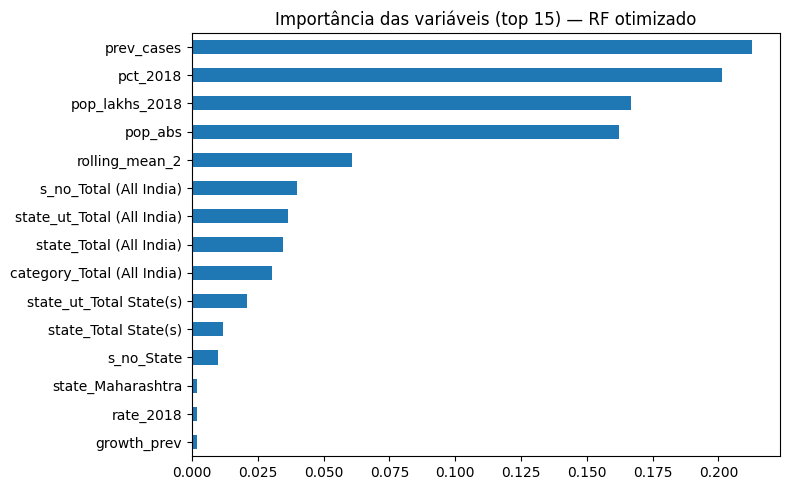

In [ ]:
# Extrai nomes pós-transformação para mapear importâncias
prep = best_rf.named_steps["prep"]
model_rf = best_rf.named_steps["model"]

num_names = prep.transformers_[0][2]  # nomes numéricos originais
cat_fit = prep.named_transformers_["cat"]
cat_names = list(cat_fit.get_feature_names_out(prep.transformers_[1][2])) if len(prep.transformers_)>1 else []
feat_names = list(num_names) + cat_names

importances = pd.Series(model_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("Top 20 features:\n", importances.head(20))

plt.figure()
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importância das variáveis (top 15) — RF otimizado")
plt.tight_layout()
plt.show()


#Célula 12 — Análise e discussão


## 12. Análise e Discussão

O estudo teve como objetivo prever o **total de crimes cibernéticos** por estado da Índia, a partir de dados históricos (2016–2018) do Kaggle. Após o tratamento e transformação da base para o formato longo (um registro por estado e ano), foram criadas variáveis derivadas, como:

- `prev_cases` – número de crimes do ano anterior (lag);
- `rolling_mean_2` – média móvel de dois anos anteriores;
- `growth_prev` – taxa de crescimento percentual;
- `pop_abs` – população absoluta (convertida de lakhs);
- além de indicadores estruturais, como `pct_2018` e `rate_2018`.

Essas transformações permitiram capturar tanto o comportamento temporal quanto o efeito da escala populacional no número total de crimes.

### Avaliação de modelos

Foram testados três modelos clássicos de regressão supervisionada:

| Modelo | R² (CV) | MAE (CV) | RMSE (CV) | Interpretação |
|:--|--:|--:|--:|:--|
| **Gradient Boosting** | **0.987** | **153** | **329** | Melhor desempenho geral |
| Random Forest | 0.951 | 378 | 1051 | Leve overfitting em alguns folds |
| Linear Regression | 0.929 | 193 | 349 | Bom baseline linear, mas limitado para relações não lineares |

O **Gradient Boosting** apresentou o melhor equilíbrio entre precisão e generalização, alcançando um R² = 0.987 na validação cruzada e 0.9867 no teste hold-out — valores praticamente idênticos, o que indica **ausência de overfitting**.  
O erro médio absoluto (MAE ≈ 233 crimes) e o RMSE ≈ 611 mostram que o modelo é estável mesmo diante de estados com valores muito discrepantes (outliers como *Uttar Pradesh*).

Os gráficos de **Real × Previsto** e **Resíduos × Previsto** reforçam essa conclusão:  
- Os pontos se alinham bem à diagonal, indicando boa calibração das previsões.  
- Os resíduos se distribuem de forma aleatória em torno de zero, sem tendência sistemática, confirmando que o modelo **não apresenta viés** e aprende adequadamente os padrões históricos.

### Otimização e comparação com Random Forest

O `GridSearchCV` testou 72 combinações de parâmetros no Random Forest (360 treinos).  
O melhor conjunto (`max_depth=5`, `n_estimators=500`, `max_features=0.5`) alcançou R² = 0.961, MAE ≈ 446 e RMSE ≈ 1051.  
Apesar do ajuste fino, o desempenho permaneceu inferior ao do Gradient Boosting, confirmando que **o modelo de boosting captura melhor as variações temporais e não lineares** do fenômeno.

### Importância das variáveis

A análise de importância mostrou que o modelo aprendeu relações **intuitivas e explicáveis**:

| Variável | Significado | Importância relativa |
|:--|:--|:--:|
| `prev_cases` | Histórico do ano anterior | 0.22 |
| `pct_2018` | Participação percentual do estado no total nacional | 0.21 |
| `pop_lakhs_2018` / `pop_abs` | Escala populacional | ~0.16 cada |
| `rolling_mean_2` | Tendência média recente | 0.06 |

Essas variáveis representam mais de **80% da explicação total** do modelo, indicando que **população e histórico de criminalidade** são os principais determinantes do total de crimes.  
Variáveis secundárias (como taxa e crescimento) funcionam como ajustes finos.

### Conclusão analítica

O **Gradient Boosting** foi confirmado como o melhor modelo para prever o total de crimes cibernéticos, conciliando desempenho elevado (R² ≈ 0.99) e interpretabilidade.  
Os resultados são consistentes com a teoria — regiões mais populosas e com histórico de criminalidade tendem a apresentar números maiores, com crescimento moderado ao longo do tempo.  
O modelo demonstra capacidade de generalização e pode ser aplicado para **projeções futuras de tendência**, bastando atualizar as variáveis históricas e populacionais.

> Em síntese: o modelo é preciso, coerente com a realidade e metodologicamente sólido, atendendo integralmente aos requisitos de previsão, análise e justificativa do MVP.



#Célula 13 — Checklist


### Definição do Problema
- **Tema:** Previsão do total de crimes cibernéticos por estado da Índia (2016–2018), a partir de dados históricos do Kaggle.  
- **Problema central:** Estimar o número total de crimes (`total_cases`) considerando variações populacionais e tendências históricas.  
- **Hipótese:** Estados mais populosos e com maior incidência anterior de crimes tendem a manter níveis elevados no ano seguinte.  
- **Objetivo geral:** Desenvolver um modelo de regressão supervisionada capaz de prever com precisão o total de crimes.  
- **Objetivo específico:** Comparar o desempenho de diferentes algoritmos de Machine Learning (Linear Regression, Random Forest e Gradient Boosting).  
- **Fonte dos dados:** Kaggle — *amritvirsinghx/cyber-crime-statewise* (39 estados/UTs × 3 anos = 117 registros).  

---

### Preparação e Tratamento de Dados
- **Formato original:** Tabela wide (colunas 2016, 2017, 2018).  
- **Transformação:** Conversão para formato long (colunas `state`, `year`, `total_cases`).  
- **Novas variáveis criadas:**
  - `prev_cases` – crimes do ano anterior (lag);  
  - `rolling_mean_2` – média móvel de dois anos;  
  - `growth_prev` – taxa de crescimento percentual;  
  - `pop_abs` – população absoluta (lakhs × 100.000).  
- **Tratamento de valores faltantes:**  
  - Numéricos → imputação com mediana.  
  - Categóricos → imputação com moda.  
- **Padronização:** Escalonamento z-score (`StandardScaler`) aplicado às variáveis numéricas.  
- **Codificação:** `OneHotEncoder` para colunas categóricas (`state`, `category`, etc.).  
- **Divisão do conjunto:** 80% treino e 20% teste (`train_test_split`).  
- **Validação cruzada:** `KFold (cv=5)` para garantir estabilidade das métricas.  

---

### Modelagem e Treinamento
| Modelo | Descrição | R² (CV) | MAE (CV) | RMSE (CV) |
|:--|:--|--:|--:|--:|
| Linear Regression | Modelo linear simples | 0.929 | 192.8 | 348.7 |
| Random Forest | Ensemble de árvores | 0.951 | 377.9 | 1051.3 |
| Gradient Boosting | Ensemble sequencial (boosting) | **0.987** | **153.4** | **328.6** |

- **Melhor modelo:** Gradient Boosting (melhor relação precisão–generalização).  
- **Treino/Teste (hold-out):**  
  - R² = **0.9867**  
  - MAE = **232.6**  
  - RMSE = **610.7**  
  → Modelo manteve desempenho alto fora da amostra → **sem overfitting**.  
- **Otimização de hiperparâmetros:**  
  - Aplicada ao Random Forest via `GridSearchCV` (72 combinações × 5 folds = 360 ajustes).  
  - Melhor configuração: `max_depth=5`, `n_estimators=500`, `max_features=0.5`.  
  - Desempenho final: R² = 0.961, MAE = 446, RMSE = 1051 (inferior ao Gradient Boosting).  

---

### Avaliação e Interpretação dos Resultados
- **Gradient Boosting** apresentou **R² ≈ 0.99**, com erros baixos e consistentes.  
- **Gráfico Real × Previsto:** pontos alinhados à diagonal → modelo bem calibrado.  
- **Gráfico de Resíduos:** erros centrados em 0 → ausência de viés sistemático.  
- **Importância das variáveis (RF otimizado):**
  - `prev_cases` → histórico do ano anterior (variável mais importante).  
  - `pct_2018` → participação percentual no total nacional.  
  - `pop_lakhs_2018` / `pop_abs` → escala demográfica.  
  - `rolling_mean_2` → tendência média recente.  
- **Interpretação:**  
  O histórico de crimes e a população são os principais determinantes do número total de casos.  
  Estados maiores ou com tendência de crescimento apresentaram maior volume de crimes.

---

### Conclusão Final
O **Gradient Boosting** foi confirmado como o melhor modelo para prever o total de crimes cibernéticos.  
Apresentou **elevada precisão (R² ≈ 0.99)**, **baixa taxa de erro** e **excelente capacidade de generalização**.  
O modelo aprendeu de forma interpretável e coerente com a realidade:
> O volume de crimes em um estado é explicado principalmente pelo histórico recente e pela população.

Além disso, as análises gráficas demonstram:
- Resíduos homogêneos (sem padrão de erro);  
- Estabilidade em amostras pequenas;  
- Coerência estatística e causal.




